In [1]:
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import xarray as xr

import magali as mg

In [2]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5


size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
data

<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[9.43164415, 9.49646333, 9.56171558, ..., 5.0615952 , 5.03496533,
        5.00842288],
       [9.53321607, 9.59901745, 9.66525782, ..., 5.10079371, 5.07376796,
        5.04683249],
       [9.63637612, 9.7031793 , 9.77042749, ..., 5.14049798, 5.11306717,
        5.08572963],
       ...,
       [5.96775674, 6.01474238, 6.06213752, ..., 1.35237245, 1.34897082,
        1.34546058],
       [5.92375941, 5.97026776, 6.01718193, ..., 1.32441902, 1.32134931,
        1.31816854],
       [5.8802674 , 5.92630586, 5.97274651, ..., 1.29696599, 1.29421848,
        1.29135761]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

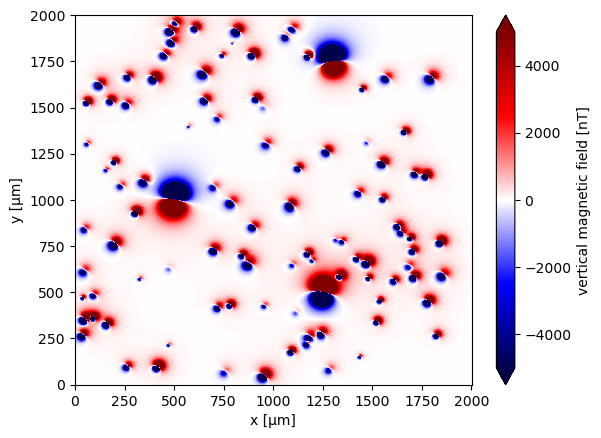

In [3]:
data.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

In [4]:
def horizontal_derivatives(data):
    """
    Compute first-order spatial derivatives in the x and y directions.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with coordinates "x" and "y".

    Returns
    -------
    dx : xr.DataArray
        First derivative along the x-direction.
    dy : xr.DataArray
        First derivative along the y-direction.
    """
    dx = hm.derivative_easting(data)
    dy = hm.derivative_northing(data)
    return dx, dy

In [5]:
def estimate_grid_spacing(data):
    """
    Estimate grid spacing as the mean difference in x and y coordinates.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with coordinates "x" and "y".

    Returns
    -------
    spacing : float
        Estimated grid spacing.
    """
    return np.mean([np.abs(data.x[1] - data.x[0]), np.abs(data.y[1] - data.y[0])])

In [6]:
def vertical_derivative(data, spacing):
    """
    Compute the first-order vertical derivative using finite differences.

    The vertical derivative is estimated using the difference between an
    upward-continued and a downward-continued version of the data. This avoids
    downward continuation, which can amplify noise.

    Parameters
    ----------
    data : xr.DataArray
        Input data array.
    spacing : float
        Grid spacing used for upward and downward continuation.

    Returns
    -------
    dz : xr.DataArray
        First derivative along the z-direction.
    """
    data_up = hm.upward_continuation(data, spacing).assign_coords(x=data.x, y=data.y)
    data_down = hm.upward_continuation(data, -spacing).assign_coords(x=data.x, y=data.y)
    return (data_up - data_down) / (2 * spacing)

In [7]:
def total_gradient_amplitude(dx, dy, dz) -> xr.DataArray:
    """
    Compute the total gradient amplitude from spatial derivatives.

    Parameters
    ----------
    dx : xr.DataArray
        First derivative along the x-direction.
    dy : xr.DataArray
        First derivative along the y-direction.
    dz : xr.DataArray
        First derivative along the z-direction.

    Returns
    -------
    tga : xr.DataArray
        Total gradient amplitude.
    """
    return np.sqrt(dx**2 + dy**2 + dz**2)

In [8]:
dx, dy = horizontal_derivatives(data)

In [9]:
spacing = estimate_grid_spacing(data)

In [10]:
dz = vertical_derivative(data, spacing)

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [11]:
tga = total_gradient_amplitude(dx, dy, dz)

In [12]:
data

<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[9.43164415, 9.49646333, 9.56171558, ..., 5.0615952 , 5.03496533,
        5.00842288],
       [9.53321607, 9.59901745, 9.66525782, ..., 5.10079371, 5.07376796,
        5.04683249],
       [9.63637612, 9.7031793 , 9.77042749, ..., 5.14049798, 5.11306717,
        5.08572963],
       ...,
       [5.96775674, 6.01474238, 6.06213752, ..., 1.35237245, 1.34897082,
        1.34546058],
       [5.92375941, 5.97026776, 6.01718193, ..., 1.32441902, 1.32134931,
        1.31816854],
       [5.8802674 , 5.92630586, 5.97274651, ..., 1.29696599, 1.29421848,
        1.29135761]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

In [13]:
def total_gradient_amplitude_grid(data):
    """
    Compute the total gradient amplitude (TGA) of a given data array.

    The function calculates the horizontal and vertical derivatives of the input data and then
    computes the total gradient amplitude.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with coordinates `x` and `y`.

    Returns
    -------
    xr.Dataset
        Dataset containing the total gradient amplitude (TGA).
    """
    dx, dy = horizontal_derivatives(data)
    spacing = estimate_grid_spacing(data)
    dz = vertical_derivative(data, spacing)
    tga = total_gradient_amplitude(dx, dy, dz)

    # Assign attributes
    tga.attrs = {"long_name": "Total Gradient Amplitude", "units": "nT/µm"}

    return tga

In [14]:
data_tga = total_gradient_amplitude_grid(data)
data_tga

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray 'tga' (y: 1001, x: 1001)> Size: 8MB
array([[6.6822762 , 2.36404408, 3.83966761, ..., 2.46636036, 3.90968942,
        0.50807766],
       [3.30426471, 1.16742281, 0.34624859, ..., 1.2909566 , 0.22381032,
        4.29868005],
       [4.52446472, 0.06683656, 1.55264025, ..., 0.03614514, 1.49322717,
        3.07698267],
       ...,
       [3.32965083, 1.27249969, 0.2815232 , ..., 1.38433029, 0.1728437 ,
        4.45729496],
       [4.48776586, 0.07596751, 1.47705989, ..., 0.111677  , 1.42546944,
        3.17632427],
       [0.94308691, 3.6754534 , 2.13355721, ..., 3.90088902, 2.3276863 ,
        6.94122792]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  Total Gradient Amplitude
    units:      nT/µm

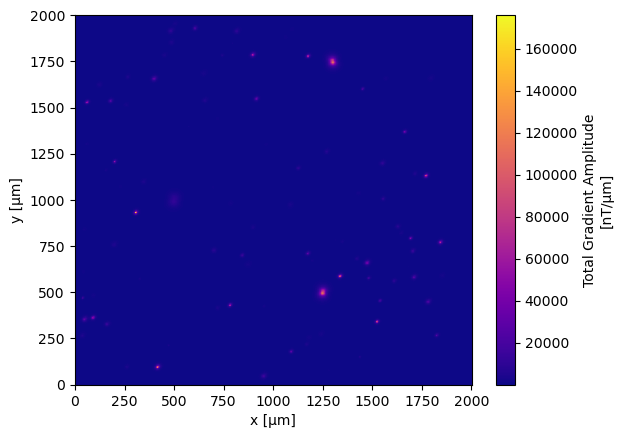

In [15]:
data_tga.plot.pcolormesh(cmap="plasma")